In [2]:
# Import the connection function from the snowexsql library
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [7]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import numpy as np
import pandas as pd
import pickle
from ulmo_extract import get_snotel_image_results
from metloom_extract import get_california_snowsites
from gee_ancillary import snow_off_phase, atmospheric_h20_diff
from multiprocessing import Pool, cpu_count
from datetime import datetime
import matplotlib.pyplot as plt
from rio_geom import rio_to_exterior

import rioxarray as rxa

## add in database stuff

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

res = pd.DataFrame()

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]

tmp_dir = expanduser(f'~/uavsar/results/uavsar_snotel_sd/tmp/')


In [13]:
from rio_geom import rio_to_exterior
from metloom.pointdata import CDECPointData, SnotelPointData, MesowestPointData
from metloom.variables import CdecStationVariables, SnotelVariables, MesowestVariables
def process(img_set):
    dic = {}
    desc = pd.read_csv(img_set['ann'], index_col = 0)
    dic['name'] = basename(img_set['fp'])
    dic['first_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 1'])
    dic['second_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 2'])
    dic['pol'] = img_set['pol']
    boundary = rio_to_exterior(img_set['fp'])
    if ', CA' in img_set['fp']:
        ca = True
        vrs = [CdecStationVariables.SWE, CdecStationVariables.SNOWDEPTH, CdecStationVariables.TEMP]
        points = CDECPointData.points_from_geometry(boundary, vrs, snow_courses=False)
    else:
        ca = False
        vrs = [SnotelVariables.SWE, SnotelVariables.SNOWDEPTH, SnotelVariables.TEMP]
        points = SnotelPointData.points_from_geometry(boundary, vrs, snow_courses=False)
    sites = points.to_dataframe()
    sites_results = {}
    for i, site in sites.iterrows():
        site_result = {}
        for label in ['fp','inc','cor','hgt']:
            img = rxa.open_rasterio(img_set[label])
            site_name = site['name']
            if label == 'fp':
                label = 'unw'
            site_result[label] = img.sel(x = site.geometry.x, y = site.geometry.y, method = 'nearest', tolerance = 0.0001).values[0]
        if ca:
            snotel_point = CDECPointData(site.id, "my name")
        else:
            snotel_point = SnotelPointData(site.id, "my name")
        try:
            site_result['meso'] = snotel_point.get_hourly_data(dic['first_dt'], dic['second_dt'], vrs)
        except:
            site_result['meso'] = np.nan
        site_result['geom'] = site.geometry
        sites_results[site_name] = site_result
    dic['snotel_results'] = sites_results
    dic['h20_atmospheric_diff'] = atmospheric_h20_diff(img_fp = img_set['fp'], ann_fp = img_set['ann'])
    with open(join(tmp_dir, basename(img_set['fp'].split('.')[0])), 'wb') as f:
        pickle.dump(dic, f)


In [14]:
dic = process(image_fps[10])

In [16]:
with open(join(tmp_dir, 'dorado_34017_20014-002_20016-000_0014d_s01_L090HH_01'), 'rb') as f:
        dic = pickle.load(f)

In [9]:
from rio_geom import rio_to_exterior
boundary_gdf = rio_to_exterior(image_fps[0]['fp'])

In [10]:
from metloom.pointdata import CDECPointData, SnotelPointData, MesowestPointData
from metloom.variables import CdecStationVariables, SnotelVariables, MesowestVariables
vrs = [SnotelVariables.SWE, SnotelVariables.SNOWDEPTH, SnotelVariables.TEMP]
points = SnotelPointData.points_from_geometry(boundary_gdf, vrs, snow_courses=False)
sites = points.to_dataframe()

In [20]:
# Import the function to get connect to the db
from snowexsql.db import get_db
from snowexsql.data import SiteData, PointData, LayerData, ImageData
from snowexsql.conversions import query_to_geopandas

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# This is what you will use for all of hackweek to access the db
engine, session = get_db(db_name)

# Its convenient to store a query like the following 
qry = session.query(LayerData)

# protect ourselves from a lot of data
qry = qry.limit(5)

result = query_to_geopandas(qry, engine)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column layers.surveyors does not exist
LINE 1: ...trument, public.layers.type, public.layers.units, public.lay...
                                                             ^

[SQL: SELECT public.layers.site_name, public.layers.date, public.layers.time_created, public.layers.time_updated, public.layers.id, public.layers.doi, public.layers.date_accessed, public.layers.instrument, public.layers.type, public.layers.units, public.layers.surveyors, public.layers.latitude, public.layers.longitude, public.layers.northing, public.layers.easting, public.layers.elevation, public.layers.utm_zone, ST_AsEWKB(public.layers.geom) AS geom, public.layers.time, public.layers.depth, public.layers.site_id, public.layers.bottom_depth, public.layers.comments, public.layers.sample_a, public.layers.sample_b, public.layers.sample_c, public.layers.value 
FROM public.layers 
 LIMIT %(param_1)s]
[parameters: {'param_1': 5}]
(Background on this error at: https://sqlalche.me/e/14/f405)

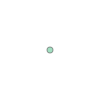

In [12]:
sites.iloc[0].geometry

In [22]:
unw = rxa.open_rasterio(image_fps[0]['cor'], masked = True)
unw = unw.rio.reproject(unw.rio.crs, resolution = 1/5000)

In [6]:
snotel_point = SnotelPointData(sites.iloc[0].id, "my name")
df = snotel_point.get_hourly_data(
    datetime(2020, 1, 2), datetime(2020, 1, 4),
    vrs
)

In [23]:
for i, r in sites.iterrows():
    res = unw.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest', tolerance = 0.0001)

In [24]:
res

<xarray.DataArray (band: 1)>
array([0.8180137], dtype=float32)
Coordinates:
    x            float64 -110.0
    y            float64 47.06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

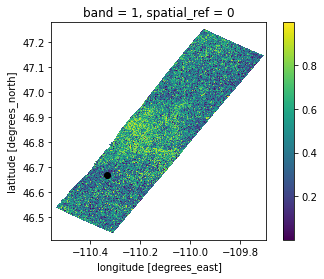

In [84]:
f, ax = plt.subplots()
unw.plot(ax = ax)
sites.plot(color = 'black', ax = ax)

In [79]:
# unw.sel(x = slice(-110.3,-110.2), y = slice(47,46.9))

In [ ]:
get_snotel_image_results(img_fp = img['fp'], inc_fp = img['inc'], cor_fp = img['cor'], ann_fp = img['ann'], box_side = 5)